# Monte Carlo Counterfactual Regret Minimization (MCCFR)

In this example we showcase how to use `cfrx` to run the MCCFR (outcome-sampling variation) on simple games Kuhn Poker, Leduc Poker.

We'll see how to:
 - Initialize an environment from `cfrx`
 - Initialize a random policy and sample a rollout
 - Write a small training loop to run the MCCFR algorithm
 - Measure the evolution of our strategy exploitability throughout the training

In [1]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.1/159.1 kB 6.8 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 33.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 22.4 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.9 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:0031m38.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.7 MB/s eta 0:00:0031m37.3 MB/s eta 0:00:01
Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)


In [2]:
import jax

jax.config.update("jax_platform_name", "cpu")

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from cfrx.algorithms.mccfr.outcome_sampling import MCCFRState, do_iteration, unroll
from cfrx.metrics import exploitability
from cfrx.policy import TabularPolicy
from cfrx.utils import regret_matching

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
from IPython.display import clear_output

def plot_partial(plot_fn, *plot_args):
    clear_output(wait=True)
    fig = plot_fn(*plot_args)
    plt.show(fig)

In [4]:
device = jax.devices("cpu")[0]

In [5]:
# Hyperparameters
ENV_NAME = "Kuhn Poker"
NUM_ITERATIONS = 100000
EXPLORATION_FACTOR = 0.6
SEED = 0
METRICS_PERIOD = 10000

random_key = jax.random.PRNGKey(SEED)

In [6]:
if ENV_NAME == "Kuhn Poker":
    from cfrx.envs.kuhn_poker.env import KuhnPoker

    env_cls = KuhnPoker


elif ENV_NAME == "Leduc Poker":
    from cfrx.envs.leduc_poker.env import LeducPoker

    env_cls = LeducPoker

## The environment

[Kuhn Poker](https://en.wikipedia.org/wiki/Kuhn_poker) is a simplified version of the Poker game. In cfrx, we use the environment from [pgx](https://github.com/sotetsuk/pgx), and add a wrapper to explicitly handle random nodes and information states.

In [7]:
env = env_cls()

In [8]:
# Number of info_sets, number of possible actions
n_states = env.n_info_states
n_actions = env.n_actions

n_states, n_actions

(13, 4)

In [9]:
s0 = env.init(random_key)
s0  # Cards haven't been dealed yet

State(current_player=Array(0, dtype=int8), observation=Array([False, False, False,  True, False,  True,  True], dtype=bool), rewards=Array([0., 0.], dtype=float32), terminated=Array(False, dtype=bool), truncated=Array(False, dtype=bool), legal_action_mask=Array([ True,  True,  True,  True], dtype=bool), _step_count=Array(0, dtype=int32), _cards=Array([-1, -1], dtype=int8), _last_action=Array(-1, dtype=int32), _pot=Array([0, 0], dtype=int32), info_state=InfoState(private_card=Array(-1, dtype=int8), action_sequence=Array([-1, -1], dtype=int8)), chance_node=Array(True, dtype=bool), chance_prior=Array([1, 1, 1], dtype=int32))

In [10]:
# Give a J to player 1 and a K to player 2
s1 = env.step(s0, action=jnp.array(0))
s2 = env.step(s1, action=jnp.array(2))
jax.tree_map(lambda *z: jnp.stack(z), s1, s2)

State(current_player=Array([0, 0], dtype=int8), observation=Array([[ True, False, False,  True, False,  True, False],
       [ True, False, False,  True, False,  True, False]], dtype=bool), rewards=Array([[0., 0.],
       [0., 0.]], dtype=float32), terminated=Array([False, False], dtype=bool), truncated=Array([False, False], dtype=bool), legal_action_mask=Array([[ True,  True,  True,  True],
       [False,  True, False,  True]], dtype=bool), _step_count=Array([1, 2], dtype=int32), _cards=Array([[ 0, -1],
       [ 0,  2]], dtype=int8), _last_action=Array([-1, -1], dtype=int32), _pot=Array([[0, 0],
       [0, 0]], dtype=int32), info_state=InfoState(private_card=Array([-1,  0], dtype=int8), action_sequence=Array([[-1, -1],
       [-1, -1]], dtype=int8)), chance_node=Array([ True, False], dtype=bool), chance_prior=Array([[0, 1, 1],
       [0, 1, 0]], dtype=int32))

## Random policy

In [11]:
# Initialize a training state
training_state = MCCFRState.init(n_states, n_actions)
jax.tree_map(np.shape, training_state)

MCCFRState(regrets=(13, 4), probs=(13, 4), avg_probs=(13, 4), step=())

In [12]:
# Initialize a Policy object and print the probability distribution for our current strategy and state
policy = TabularPolicy(
    n_actions=n_actions,
    exploration_factor=EXPLORATION_FACTOR,
    info_state_idx_fn=env.info_state_idx,
)

policy.prob_distribution(
    params=training_state.probs,
    info_state=s2.info_state,
    action_mask=s2.legal_action_mask,
    use_behavior_policy=jnp.bool_(False),
)

Array([0. , 0.5, 0. , 0.5], dtype=float32)

In [13]:
# Let's do an unroll with our uniformly-random Policy
random_key, subkey = jax.random.split(random_key)
episode, states = unroll(
    init_state=s2,
    training_state=training_state,
    random_key=subkey,
    update_player=0,
    env=env,
    policy=policy,
    n_max_steps=env.max_episode_length,
)

Print out the action sequence "b" means "bet" and "p" pass

In [14]:
jax.tree_map(lambda x: x[~states.terminated], states)

State(current_player=Array([0, 1], dtype=int8), observation=Array([[ True, False, False,  True, False,  True, False],
       [False, False,  True,  True, False, False,  True]], dtype=bool), rewards=Array([[0., 0.],
       [0., 0.]], dtype=float32), terminated=Array([False, False], dtype=bool), truncated=Array([False, False], dtype=bool), legal_action_mask=Array([[False,  True, False,  True],
       [ True, False,  True, False]], dtype=bool), _step_count=Array([2, 3], dtype=int32), _cards=Array([[0, 2],
       [0, 2]], dtype=int8), _last_action=Array([-1,  1], dtype=int32), _pot=Array([[0, 0],
       [1, 0]], dtype=int32), info_state=InfoState(private_card=Array([0, 2], dtype=int8), action_sequence=Array([[-1, -1],
       [ 1, -1]], dtype=int8)), chance_node=Array([False, False], dtype=bool), chance_prior=Array([[0, 1, 0],
       [0, 1, 0]], dtype=int32))

In [15]:
"".join(
    [env_cls.action_to_string(x) for x in episode.action[episode.mask.astype(bool)]]
)

'bp'

## MCCFR implementation
We use the `cfrx` components to implement the MCCFR algorithm.

The algorithm consists in alternating iterations for the two players, and logging the exploitability from time to time.

Note: We make sure to Jit both the iteration and exploitability function, to make the most of Jax capabilities.

In [16]:
# This function samples a trajectory, compute counterfactual regrets and update the policy accordingly
do_iteration_fn = jax.jit(
    lambda training_state, random_key, update_player: do_iteration(
        training_state=training_state,
        random_key=random_key,
        env=env,
        policy=policy,
        update_player=update_player,
    )
)

In [17]:
# This function measures the exploitability of a strategy
exploitability_fn = jax.jit(
    lambda policy_params: exploitability(
        policy_params=policy_params,
        env=env,
        n_players=env.n_players,
        n_max_nodes=env.max_nodes,
        policy=policy,
    ),
    device=device,
)

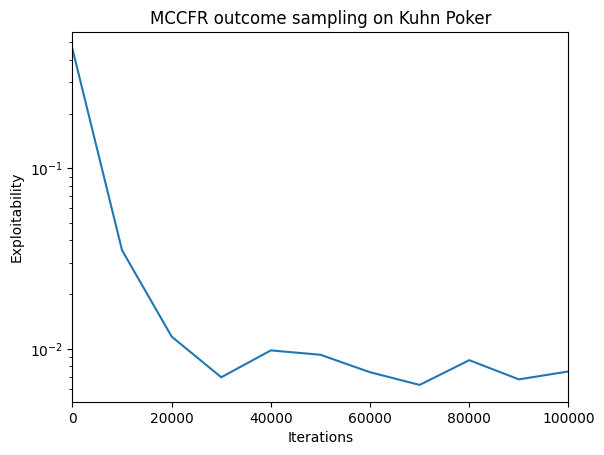

In [18]:
# One iteration consists in updating the policy for both players
n_loops = 2 * NUM_ITERATIONS

exploitabilities = []
iterations = []

for k in range(n_loops):
    random_key, subkey = jax.random.split(random_key)

    # Update players alternatively
    update_player = k % 2
    training_state = do_iteration_fn(
        training_state=training_state,
        random_key=subkey,
        update_player=update_player,
    )

    # Logging
    if k == 0 or (k + 1) % (METRICS_PERIOD * 2) == 0:
        current_policy = training_state.avg_probs
        current_policy /= training_state.avg_probs.sum(axis=-1, keepdims=True)

        exp = exploitability_fn(policy_params=current_policy)

        exploitabilities.append(exp)
        iterations.append(k // 2)
        plt.xlabel("Iterations")
        plt.title(f"MCCFR outcome sampling on {ENV_NAME}")
        plt.ylabel("Exploitability")
        plt.yscale("log")
        plt.xlim(0, NUM_ITERATIONS)

        plot_partial(plt.plot, iterations, exploitabilities)

All this logic is also implemented inside a trainer, which is further optimized to reduce the runtime

In [19]:
from cfrx.trainers.mccfr import MCCFRTrainer

In [20]:
trainer = MCCFRTrainer(env=env, policy=policy)

In [21]:
training_state = trainer.train(
    random_key=random_key, n_iterations=NUM_ITERATIONS, metrics_period=METRICS_PERIOD
)

Training: 100%|█████| 100k/100k [00:02<00:00, 36.5kit/s, exploitability=7.4e-03]
